# **Installing necessary dependencies**

In [ ]:
! pip install googletrans==3.1.0a0
! pip install langdetect
! pip install vaderSentiment
! pip install textblob

# **Importing Libraries**

In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
import string
from langdetect import detect
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Loading the dataset**

In [ ]:
tweets = pd.read_csv('/content/multilingual tweets.csv', encoding='ISO-8859-1')
tweets = tweets[:200]

# **Exploratory Data Analysis**

In [ ]:
tweets.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets
0,4.342160e+17,TR,2/14/2014,BugÃ¼n bulusmami lazimdiii,0,0,1,0,0,0
1,2.859030e+17,TR,1/1/2013,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0
2,2.859480e+17,NL,1/1/2013,Bed,1,0,0,0,0,0
3,2.859660e+17,US,1/1/2013,I felt my first flash of violence at some fool...,1,0,0,0,0,0
4,2.860580e+17,US,1/1/2013,Ladies drink and get in free till 10:30,1,0,0,0,0,0


In [ ]:
tweets.columns

Index(['Tweet ID', 'Country', 'Date', 'Tweet', 'Definitely English',
       'Ambiguous', 'Definitely Not English', 'Code-Switched',
       'Ambiguous due to Named Entities', 'Automatically Generated Tweets'],
      dtype='object')

In [ ]:
print('length of data is', len(tweets))

length of data is 200


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Tweet ID                         200 non-null    float64
 1   Country                          200 non-null    object 
 2   Date                             200 non-null    object 
 3   Tweet                            200 non-null    object 
 4   Definitely English               200 non-null    int64  
 5   Ambiguous                        200 non-null    int64  
 6   Definitely Not English           200 non-null    int64  
 7   Code-Switched                    200 non-null    int64  
 8   Ambiguous due to Named Entities  200 non-null    int64  
 9   Automatically Generated Tweets   200 non-null    int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 15.8+ KB


In [ ]:
tweets.isnull().sum()

Tweet ID                           0
Country                            0
Date                               0
Tweet                              0
Definitely English                 0
Ambiguous                          0
Definitely Not English             0
Code-Switched                      0
Ambiguous due to Named Entities    0
Automatically Generated Tweets     0
dtype: int64

# **Detecting and Translating tweets**

In [ ]:
def detect_language(tweet):
    try:
        lang = detect(tweet)
    except:
        lang = 'Other'
    return lang
tweets['Language'] = tweets['Tweet'].apply(lambda x: detect_language(x))
tweets = tweets[tweets['Language'] != 'Other']

In [ ]:

translated = []
for index, row in tweets.iterrows():
    translator = Translator()
    translation = translator.translate(row['Tweet'],src = row['Language'],dest="en")
    translated.append(translation.text)

tweets['Translated']=translated



<BarContainer object of 10 artists>

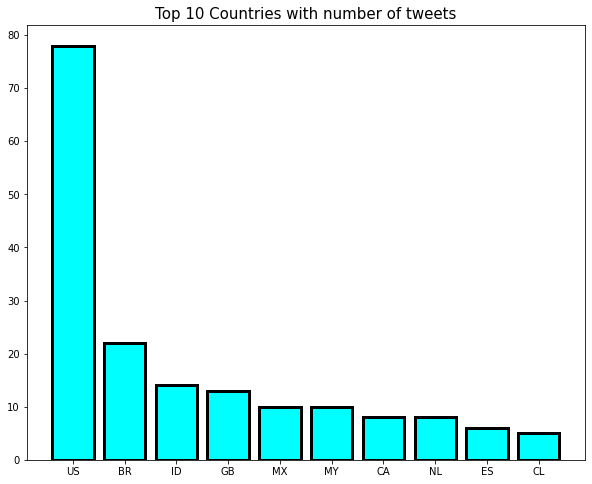

In [ ]:
import matplotlib.pyplot as plt
country_df = tweets.groupby('Country')[['Tweet']].count()
country_df = country_df.nlargest(10,'Tweet')
plt.figure(figsize = (10,8))
plt.title('Top 10 Countries with number of tweets', fontsize = 15)
plt.bar(country_df.index, country_df.Tweet, color = 'cyan', linewidth = 3, edgecolor = 'k')

<BarContainer object of 10 artists>

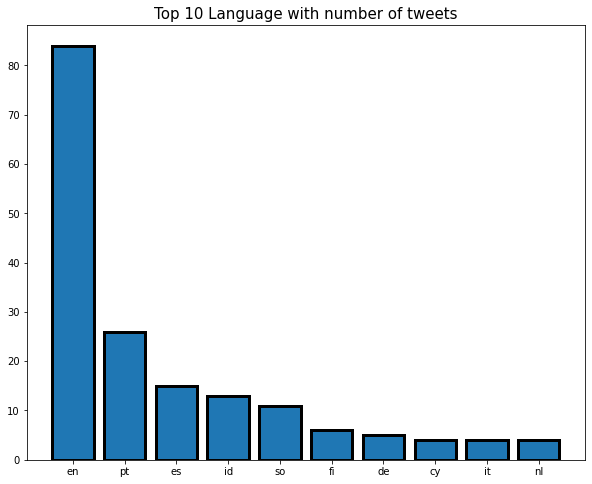

In [ ]:
country_df = tweets.groupby('Language')[['Tweet']].count()
country_df = country_df.nlargest(10,'Tweet')
plt.figure(figsize = (10,8))
plt.title('Top 10 Language with number of tweets', fontsize = 15)
plt.bar(country_df.index, country_df.Tweet, linewidth = 3, edgecolor = 'k')

# **Text Preprocessing**

In [ ]:
tweets["Translated"] = tweets["Translated"].str.lower()


def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
tweets["Translated"] = tweets["Translated"].apply(lambda text: remove_urls(text))

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

tweets["Translated"] = tweets["Translated"].apply(lambda text: remove_punctuation(text))
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
tweets["Translated"] = tweets["Translated"].apply(lambda text: remove_emoji(text))
tweets['Translated']=tweets['Translated'].apply(str)
tweets['Translated']=tweets['Translated'].apply(lambda x:word_tokenize(x))

def remove_stopwords(words):
    stop_words=set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]
tweets['Translated']=tweets['Translated'].apply(lambda x: remove_stopwords(x))


def lemmatizing(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
tweets['Translated']=tweets['Translated'].apply(lambda x: lemmatizing(x))

def final_text(words):
     return ' '.join(words)
tweets['Translated']=tweets['Translated'].apply(lambda x:final_text(x))
   

# **Feature Engineering**

In [ ]:
def getSubjectivity(text): # function to get subjectivity scores
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text): # function to get polarity scores
    return TextBlob(text).sentiment.polarity

# applying the functions getSubjectivity and getPolarity on the Translated data
# creating new feature for subjectivity and polarity
tweets['Subjectivity'] = tweets['Translated'].apply(lambda x: getSubjectivity(x))
tweets['Polarity'] = tweets['Translated'].apply(lambda x: getPolarity(x))

In [ ]:
tweets.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets,Language,Translated,Subjectivity,Polarity
0,4.342160e+17,TR,2/14/2014,BugÃ¼n bulusmami lazimdiii,0,0,1,0,0,0,tr,bugã¼n bulusmami lazimdiii,0.000000,0.000
1,2.859030e+17,TR,1/1/2013,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0,id,volkan konak adami tribe sokar yemin ederim,0.000000,0.000
2,2.859480e+17,NL,1/1/2013,Bed,1,0,0,0,0,0,de,bed,0.000000,0.000
3,2.859660e+17,US,1/1/2013,I felt my first flash of violence at some fool...,1,0,0,0,0,0,en,felt first flash violence fool bumped pity fool,0.266667,0.075
4,2.860580e+17,US,1/1/2013,Ladies drink and get in free till 10:30,1,0,0,0,0,0,af,lady drink get free till 1030,0.800000,0.400


# **Sentiment Analysis**

In [ ]:
def getSentimentScore(text): #function to get sentiment scores
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

compound = []
for i in tweets['Translated']:
    SIA = getSentimentScore(i)
    compound.append(SIA['compound'])

tweets['Compound'] = compound

# Creating label from compond features
label = []
for i in tweets['Compound']:
    if i>0:
        label.append(1)
    else:
        label.append(0)
tweets['Label'] = label
tweets[['Translated','Language','Subjectivity','Polarity','Label']].head()

,Translated,Language,Subjectivity,Polarity,Label
0,bugã¼n bulusmami lazimdiii,tr,0.000000,0.000,0
1,volkan konak adami tribe sokar yemin ederim,id,0.000000,0.000,0
2,bed,de,0.000000,0.000,0
3,felt first flash violence fool bumped pity fool,en,0.266667,0.075,0
4,lady drink get free till 1030,af,0.800000,0.400,1


# **Splitting our data into Train and Test Subset**

In [ ]:
train_df = tweets[['Translated','Subjectivity','Polarity','Label']][:-50]
test_df = tweets[['Translated','Subjectivity','Polarity','Label']][-50:] 

# **Transforming Dataset using TF-IDF Vectorizer**

In [ ]:
vect=TfidfVectorizer(min_df=3
                      ,analyzer="word",  ngram_range=(1,3) 
                           ).fit(train_df['Translated'])
x_train_vect=vect.fit_transform(train_df['Translated'])
# Combining textual as well as numerical features in training set
X = np.hstack((x_train_vect.todense(), train_df.drop(['Label','Translated'], axis = 1)))


# **Machine Learning Modelling**


In [ ]:
model1 = DecisionTreeClassifier()
model1.fit(X,train_df['Label'])
# Prediction on the test data
predictions=model1.predict(np.hstack((vect.transform(test_df['Translated']).todense(),
                                      test_df.drop(['Label','Translated'], axis = 1))))
accuracy_dtc = round(accuracy_score(test_df['Label'], predictions)*100,2)
f1_dtc = round(f1_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Decision Tree Classifier : {}'.format(accuracy_dtc))

Accuracy of Decision Tree Classifier : 82.0


In [ ]:

model2=RandomForestClassifier(n_estimators = 300, criterion = 'entropy',
                             min_samples_split=10, random_state=0)
model2.fit(X,train_df['Label'])
predictions=model2.predict(np.hstack((vect.transform(test_df['Translated']).todense(),test_df.drop(['Label','Translated'], axis = 1))))
accuracy_rfc = round(accuracy_score(test_df['Label'], predictions)*100,2)
f1_rfc = round(f1_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Random Forest Classifier : {}'.format(accuracy_rfc))

Accuracy of Random Forest Classifier : 86.0


In [ ]:
model3=SVC()
model3.fit(X,train_df['Label'])
predictions=model3.predict(np.hstack((vect.transform(test_df['Translated']).todense(),test_df.drop(['Label','Translated'], axis = 1))))
accuracy_svc = round(accuracy_score(test_df['Label'], predictions)*100,2)
f1_svc = round(f1_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Support Vector Machine : {}'.format(accuracy_svc))

Accuracy of Support Vector Machine : 86.0


In [ ]:
model4=LogisticRegression()
model4.fit(X,train_df['Label'])
predictions=model4.predict(np.hstack((vect.transform(test_df['Translated']).todense(),test_df.drop(['Label','Translated'], axis = 1))))
accuracy_lr = round(accuracy_score(test_df['Label'], predictions)*100,2)
f1_lr = round(f1_score(test_df['Label'], predictions)*100,2)
print('Accuracy of Logistic Regression : {}'.format(accuracy_lr))

Accuracy of Logistic Regression : 84.0


In [ ]:

model5= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
model5.fit(X,train_df['Label'])
predictions=model5.predict(np.hstack((vect.transform(test_df['Translated']).todense(),test_df.drop(['Label','Translated'], axis = 1))))
accuracy_knn = round(accuracy_score(test_df['Label'], predictions)*100,2)
f1_knn = round(f1_score(test_df['Label'], predictions)*100,2)
print('Accuracy of KNeighbors Classifier : {}'.format(accuracy_knn))

Accuracy of KNeighbors Classifier : 86.0


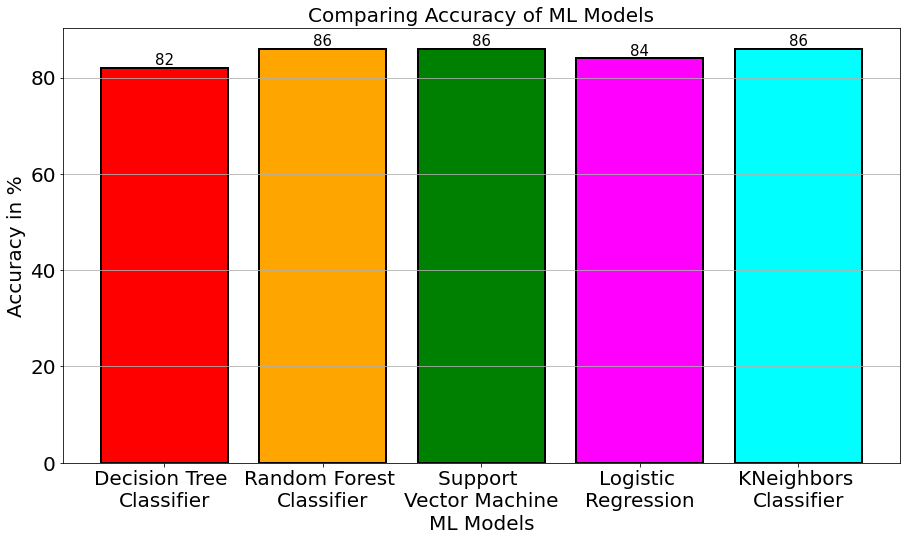

In [ ]:
accuracy_scores = [accuracy_dtc, accuracy_rfc, accuracy_svc, accuracy_lr, accuracy_knn]
model_names = ['Decision Tree \nClassifier', 'Random Forest \nClassifier', 'Support \nVector Machine',
               'Logistic \nRegression', 'KNeighbors \nClassifier']

plt.figure(figsize=(15,8))

plt.grid(b=True, which='major', axis='y')
plt.title('Comparing Accuracy of ML Models',fontsize=20)
colors=['red','orange','green','magenta','cyan']
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Accuracy in %',fontsize=20)
plt.xlabel('ML Models',fontsize=20)
bar = plt.bar(model_names,accuracy_scores,edgecolor='black',color=colors, linewidth=2)
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2, 1.0*(h), '%d'%int(h),
                    ha='center', va='bottom',fontsize=15)
autolabel(bar)

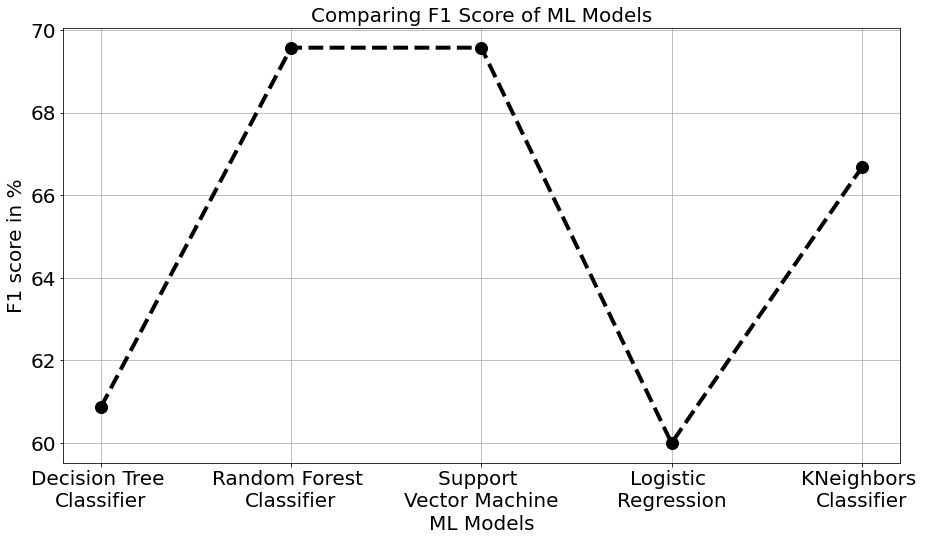

In [ ]:
f1_scores = [f1_dtc, f1_rfc, f1_svc, f1_lr, f1_knn]
plt.figure(figsize=(15,8))

plt.grid(b=True, which='major', axis='both')
plt.title('Comparing F1 Score of ML Models',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('F1 score in %',fontsize=20)
plt.xlabel('ML Models',fontsize=20)
bar = plt.plot(model_names,f1_scores,'ko--', linewidth=4, markersize=12)
# def autolabel(rects):
#     for rect in rects:
#         h = rect.get_height()
#         plt.text(rect.get_x()+rect.get_width()/2, 1.0*(h), '%d'%int(h),
#                     ha='center', va='bottom',fontsize=15)
# autolabel(bar)